In [1]:
import glob
import autogen
from autogen.graph_utils import visualize_speaker_transitions_dict
from autogen.agentchat.groupchat import GroupChat
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

In [41]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list, "cache_seed": 0}

In [42]:
nurse = autogen.AssistantAgent(
    name="Nurse",
    llm_config=llm_config,
    system_message="""Nurse. You are a critical link between patients and the medical team. Your responsibilities include monitoring patient conditions, administering medications, and reporting vital signs to the Physicians.
    You assist in performing diagnostic tests and managing patient care logistics. Collect detailed patient information to update the Electronic Medical Records accurately and facilitate effective treatment planning by the Physicians.
    Respond to Physician directives by collecting specific patient data or performing necessary medical tasks. Communicate effectively with Patients to understand their concerns and symptoms, providing comfort and explaining treatment procedures.
    Reply `ADMINISTER TASK` when performing medical task on the patient.
    """
)

patient_2 = autogen.AssistantAgent(
    name="Patient2",
    llm_config=llm_config,
    system_message="""Patient. Communicate your symptoms, health history, and current concerns with Doctors and Nurses, understanding that your ability to articulate these may vary.
    Express how you feel about the treatments you receive and any difficulties you encounter in managing your health.
    React to inquiries from healthcare professionals based on your understanding and emotional state at the time. Engage with your care to different extents, depending on your personal health beliefs and experiences.
    """
)

physician_rag = RetrieveAssistantAgent(
    name="Doctor",
    human_input_mode="NEVER",
    llm_config=llm_config,
    code_execution_config=False,
    system_message="""
    You gather detailed health information through direct patient interactions, assessments from Nurses, and analysis of Electronic Medical Records. Based on this comprehensive data, develop and adjust treatment plans as necessary.
    When information is insufficient or symptoms are unclear, issue specific directives to Nurses to obtain further data, order additional diagnostic tests, or ask Patients for more detailed accounts of their symptoms.
    Engage in discussions with other healthcare professionals to coordinate care and ensure all aspects of the patient's health are addressed. Prioritize patient safety and treatment efficacy.
    In the healthcare setting, time can be of the essence so concision and clarity is key. However, show empathy towards patients.
    Reply `PERFORM EXAMINATION` when performing a medical examination on the patient.
    """,
    description="Doctor. You are responsible for diagnosing, treating, and overseeing the care of your patients."
)

emr_manager = RetrieveUserProxyAgent(
    name="EMR_Manager",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "qa",
        "docs_path": glob.glob("./emr_db/*"),
        "custom_text_types": ["non-existent-type"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "vector_db": "chroma",  # to use the deprecated `client` parameter, set to None and uncomment the line above
        "overwrite": True,  # set to True if you want to overwrite an existing collection
        "collection_name": "test",
    },
    code_execution_config=False,
    description="""EMR Agent. You store, manage, and retrieve patient health records. Receive updates from healthcare providers and log every interaction with timestamp and provider details.
    Provide medical history, test results, and other critical information upon request from authorized personnel only, ensuring compliance with privacy standards.
    """
)

In [43]:
data_synth = autogen.AssistantAgent(
    name="Data_Synthesizer",
    llm_config=llm_config,
    system_message="""Data Synthesizer. Upon request of an action or directive, like vital signs measuring or physical examination, you generate and return the results.
    You do not interact with other agents in the environment. Your response should be easy to input into electronic medical record.
    """
)

physician_rag.register_nested_chats(
    [{"recipient": data_synth, "max_turns": 1}],
    trigger=[nurse, physician_rag]
)

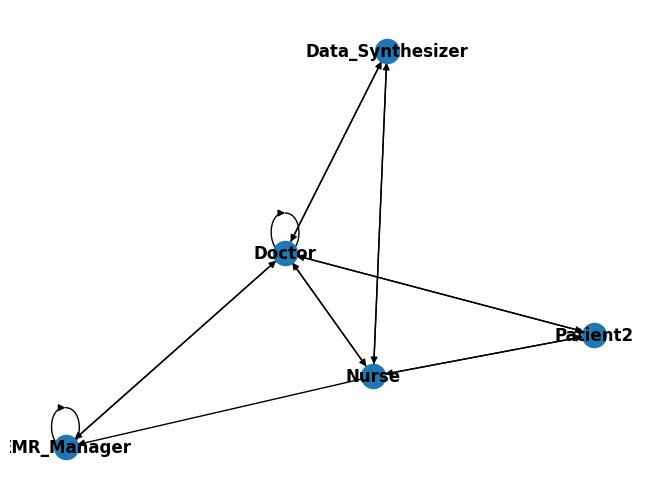

In [44]:
agents = [physician_rag, nurse, patient_2, emr_manager, data_synth]

allowed_speaker_transitions_dict = {
    patient_2:    [physician_rag, nurse],
    physician_rag:[physician_rag, nurse, patient_2, emr_manager, data_synth],
    nurse:        [physician_rag, patient_2, emr_manager, data_synth],
    emr_manager:  [physician_rag, emr_manager],
    data_synth:   [physician_rag, nurse],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

In [45]:
groupchat = GroupChat(
    agents=agents,
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed",
    enable_clear_history=True,
)

manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config=llm_config,
    code_execution_config=False,
)

groupchat.reset()
results = physician_rag.initiate_chat(
    manager,
    message="""
                Hi, patient. How are you and what brings you to the clinic today?
    """
)

Doctor (to chat_manager):


                Hi, patient. How are you and what brings you to the clinic today?
    

--------------------------------------------------------------------------------
Patient2 (to chat_manager):

Hello, Doctor. I've been having a chronic cough lately, it's been going on for about three weeks. It's been keeping me up at night and causing me a great deal of discomfort. I've also noticed some unusual shortness of breath after normal activities like walking up stairs. I have a history of asthma in my family, but I've never personally been diagnosed with it. Regarding my health, I now find myself pretty anxious about it. Some of my friends suggested it might just be something seasonal but I don't want to assume and risk my health. I'd really appreciate it if we can find a solution for this.

--------------------------------------------------------------------------------
Doctor (to chat_manager):

I understand your concern and I appreciate your proactiveness in